# Some classic techniques in data science

Author: Juvid Aryaman

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mystyle.sty as sty

In [2]:
sty.reset_plots()

## 1. K-means clustering

### Create synthetic data

In [3]:
from sklearn.datasets import make_blobs
import matplotlib.cm as cm

In [4]:
n_samples = 500
n_features = 2 # 2D data
K = 4

X, y = make_blobs(n_samples, n_features, K, random_state=1)

In [5]:
X.shape, y.shape

((500, 2), (500,))

/home/juvid/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


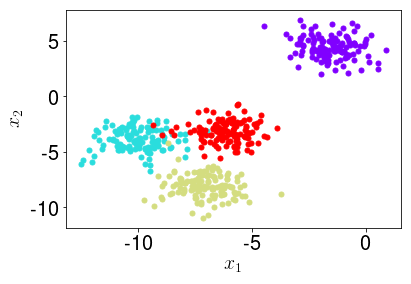

In [6]:
colors = cm.rainbow(np.linspace(0,1,K))
fig, ax = plt.subplots(1,1)
for i in range(K):
    ax.plot(X[y==i,0], X[y==i,1], marker='.', linestyle='None',
            color = colors[i])
sty.remove_tex_axis(ax)
ax.set_xlabel('$x_1$')    
ax.set_ylabel('$x_2$');   

### Perform K-means clustering

Initialise clusters as a random choice from the data

In [7]:
def assign_closest_cluster(X, cluster_positions, K):
    """
    Assign each data point to its closest cluster
    
    Parameters
    --------------
    X : An (n_data,n_features) numpy array, the design matrix
    cluster_positions : A (K,n_features) numpy array, the cluster positions
    K : An int, the number of clusters
    
    Returns
    --------------
    closest_cluster : A numpy vector of length K, the closest cluster
        for each data point
    total_sq_distance : The total square distance between all points 
        and their assigned cluster
    """
    n_data = len(X)
    distances_to_clusters = np.zeros((n_data,K))
    total_square_res = 0
    for i in range(K):
        res = X - cluster_positions[i]
        square_res = res*res
        distances_to_clusters[:,i] = np.sum(square_res, axis=1)        
    closest_cluster = np.argmin(distances_to_clusters, axis=1)
    # This next line is a bit tricky!
    total_sq_distance = np.sum(distances_to_clusters[range(n_data),
                                                     closest_cluster])
    return closest_cluster, total_sq_distance


In [8]:
def update_cluster_positions(X, closest_cluster, K, n_features):
    """
    Compute the position of the cluster, given each data point's 
    closest cluster
    
    Parameters
    ---------------
    X : An (n,n_features) numpy array, the design matrix
    closest_cluster : A numpy vector of length K, the closest cluster
        for each data point
    K : An int, the number of clusters
    n_features : An int, the number of features for each data point   
    
    Returns
    --------------
    cluster_positions : An (K, n_features) array, the new cluster 
        positions which is the mean position of the assigned
        data
    """
    cluster_positions = np.zeros((K,n_features))
    for i in range(K):
        cluster_positions[i,:] = np.mean(X[closest_cluster==i,:], 
                                         axis=0)
    return cluster_positions

In [9]:
np.random.seed(1)

# Initialise clusters with the Forgy method 
cluster_positions = X[np.random.choice(len(X), 
                                      size=K, replace=False),:]
err = 1
err_new = 100

n_iters_max = 25
i = 0
errors = []
cluster_positions_all = []
while((not np.isclose(err, err_new, rtol=1e-5)) and (i <= n_iters_max)):
    err = err_new
    closest_cluster, err_new = assign_closest_cluster(X,
                                      cluster_positions, K)  
    cluster_positions = update_cluster_positions(X, 
                                     closest_cluster, K, n_features)
    errors.append(err_new)
    cluster_positions_all.append(closest_cluster)
    i+=1
n_iterations = i - 1
print('Iterations = {}'.format(i))

Iterations = 11


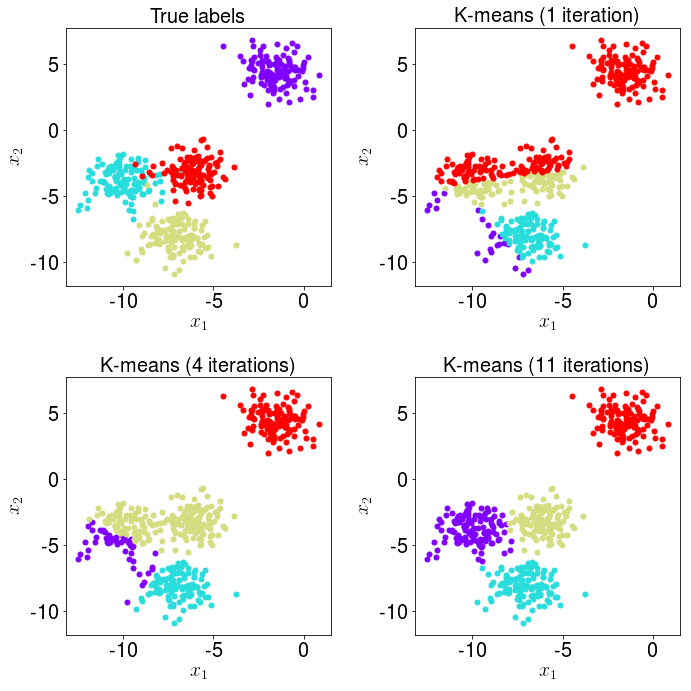

In [10]:
fig, axs = plt.subplots(2,2, figsize=(5*2,5*2))
axs = axs.ravel()

ax = axs[0]
for i in range(K):
    ax.plot(X[y==i,0], X[y==i,1], marker='.', linestyle='None',
            color = colors[i])
sty.remove_tex_axis(ax)
ax.set_xlabel('$x_1$')    
ax.set_ylabel('$x_2$')
ax.set_title('True labels')

ax = axs[1]
for i in range(K):
    ax.plot(X[cluster_positions_all[0]==i,0], 
            X[cluster_positions_all[0]==i,1], 
            marker='.', linestyle='None',
            color = colors[i])
sty.remove_tex_axis(ax)
ax.set_xlabel('$x_1$')    
ax.set_ylabel('$x_2$')
ax.set_title('K-means (1 iteration)');  

ax = axs[2]
for i in range(K):
        ax.plot(X[cluster_positions_all[3]==i,0], 
                X[cluster_positions_all[3]==i,1], 
                marker='.', linestyle='None',
            color = colors[i])
sty.remove_tex_axis(ax)
ax.set_xlabel('$x_1$')    
ax.set_ylabel('$x_2$')
ax.set_title('K-means ({} iterations)'.format(3+1));

ax = axs[3]
for i in range(K):
        ax.plot(X[cluster_positions_all[n_iterations]==i,0], 
                X[cluster_positions_all[n_iterations]==i,1], 
                marker='.', linestyle='None',
            color = colors[i])
sty.remove_tex_axis(ax)
ax.set_xlabel('$x_1$')    
ax.set_ylabel('$x_2$')
ax.set_title('K-means ({} iterations)'.format(n_iterations+1))
plt.tight_layout()

## 2. Logistic regression

Logistic regression is often used when we wish to perform supervised classification for a binary variable $y \in \{0,1\}$ from feature vectors $\boldsymbol{x}_i \in \mathbb{R}^D$. The likelihood for a single observation takes the form

$$p(y|\boldsymbol{x}, \boldsymbol{w}) = Ber(y|\mu(\boldsymbol{x})) = \mu(\boldsymbol{x})^y(1-\mu(\boldsymbol{x}))^{1-y}$$

where $Ber(y|\mu)$ is a Bernoulli random variable where the probability of success is $\mu$. We choose $\mu$ to be a logistic function of the explanatory variable $\boldsymbol{x}$

$$\mu(\boldsymbol{x}) = \frac{1}{1+\exp(-\boldsymbol{w}^T\boldsymbol{x})} $$

We seek to find a maximum-likelihood estimate for the weights $\boldsymbol{w}$. The log-likelihood for this model ($\mathcal{L}(\boldsymbol{w}) = \log(\Pi_i^N p(y|\boldsymbol{x}, \boldsymbol{w})$) over all the data is

$$\mathcal{L}(\boldsymbol{w}) = \sum_{i=1}^N y_i \log(\mu(\boldsymbol{x}_i)) + (1-y_i) \log(1-\mu(\boldsymbol{x}_i)). $$

To compute the maximum likelihood, we need the derivative of $\mathcal{L}(\boldsymbol{w})$. To do so, we may write $\mathcal{L}(\boldsymbol{w})$ the more convenient form

$$\mathcal{L}(\boldsymbol{w}) = \sum_{i=1}^N -\log(1+\exp(+\boldsymbol{w}^T\boldsymbol{x}_i))+y_i \boldsymbol{w}^T \boldsymbol{x}_i.$$

Since 

$$\frac{\partial}{\partial w_j} \log(1+\exp(+\boldsymbol{w}^T\boldsymbol{x}_i)) = x_{ij}\mu(\boldsymbol{x}_i)$$
$$\frac{\partial}{\partial w_j} y_i \boldsymbol{w}^T \boldsymbol{x}_i = y_i x_{ij}$$

then

$$\frac{\partial}{\partial w_j} \mathcal{L}(\boldsymbol{x}) = \sum_{i=1}^N(y_i - \mu(\boldsymbol{x}_i))x_{ij} $$

One normally minimizes $-\mathcal{L}(\boldsymbol{w})/N$ for numerical reasons.

### Make synthetic data

In [11]:
from sklearn.datasets import make_circles

In [12]:
X, y = make_circles(factor=0.7, random_state=0, 
                    noise=0.1, n_samples=150)

In [13]:
X.shape, y.shape

((150, 2), (150,))

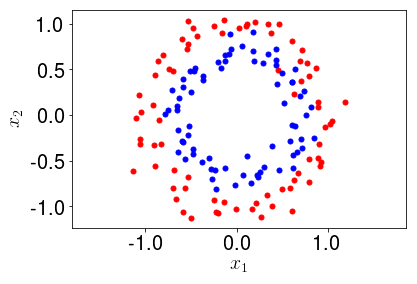

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(X[y==0,0], X[y==0,1], '.r')
ax.plot(X[y==1,0], X[y==1,1], '.b')
sty.remove_tex_axis(ax, xtick_fmt="%.1f", ytick_fmt="%.1f")
ax.set_xlabel('$x_1$')    
ax.set_ylabel('$x_2$')
ax.axis('equal');   

Since this data is not linearly separable, let's use non-linear features $x_1^2, x_2^2$. We could in general use a large a set of higher-order polynomial, use a sparsity-promoting prior (e.g. Laplace, corresponding to L1 regularization), and compute the maximum a posteriori estimate. But for simplicity, we think these features should do the job, since we just need to describe a zero-centred circle.

**NB:** One of the data columns should be a vector of ones. We want to learn the equation

$$x_1^2 + x_2^2 = r^2.$$

Now, our decision boundary is 

$$\frac{1}{2} = \frac{1}{1+\exp(-\boldsymbol{w}^T\boldsymbol{x})}$$

resulting in the equation

$$\boldsymbol{w}^T\boldsymbol{x} = 0$$

So we need to learn a bias weight (radius of the circle), which corresponds to having a constant feature vector.

In [15]:
X_nl = np.ones((len(X),3)) 
X_nl[:,1:] = X**2 # non-linear features
X_nl.shape

(150, 3)

### Perform logistic regression on non-linear features

In [16]:
def sigm(x,w):
    return 1./(1+np.exp(-np.dot(x,w)))

In [17]:
def LR_cost_function(w, X, y, reg=0.0):
    """
    Cost function for logistic regression 
    """
    
    n_data = float(len(X))
    mu = sigm(X,w)
    J = -np.sum(y*np.log(mu) + (1. - y)*np.log(1. - mu))/n_data
    J_reg = reg*np.dot(w,w)/n_data
    return J + J_reg
    

In [18]:
def grad_LR_cost_function(w, X, y, reg=0.0):
    """
    Derivative of LR_cost_function
    """
    n_data = float(len(X))
    derivs = []
    for i, wi in enumerate(w):
        grad = np.sum((sigm(X,w) - y)*X[:,i])
        grad_reg = reg*wi
        derivs.append(grad+grad_reg)
    return np.array(derivs)/n_data
        

In [19]:
def gradient_descent(w, X, y, lr):
    return w - lr*grad_LR_cost_function(w, X, y)

In [20]:
np.random.seed(1)

i=0
iter_max = 10000
lr = 0.1

w = np.random.uniform(-5,5,size=X_nl.shape[1])
err = LR_cost_function(w, X_nl, y)
err_new = 1.0

while (not np.isclose(err, err_new, rtol=1e-4)) and (i <= iter_max):                
    if i % 100 == 0:
        print(i, err)
    err = err_new
    
    w_new = gradient_descent(w, X_nl, y, lr)
    err_new = LR_cost_function(w_new, X_nl, y)
    
    w = w_new
    i+=1
    
    

0 1.1350883000403982
100 0.7967629086508738
200 0.6503313893549076
300 0.5517305873032704
400 0.48728501704307764
500 0.44497118511594974
600 0.4156809476040514
700 0.39394099058992765
800 0.3767542150562744
900 0.3625016639924118
1000 0.3502827230321941
1100 0.33956919641490535
1200 0.33003075867340137
1300 0.32144666909497904
1400 0.3136601124942465
1500 0.3065537727857941
1600 0.3000362081311544
1700 0.29403388183594836
1800 0.2884862584589496
1900 0.28334262730977894
2000 0.27855994185398936
2100 0.2741012840455621
2200 0.2699347308925847
2300 0.26603249144892244
2400 0.2623702330324424
2500 0.2589265445891728
2600 0.25568250246899243
2700 0.252621314589787
2800 0.2497280258248935
2900 0.24698927199673912
3000 0.24439307297739976


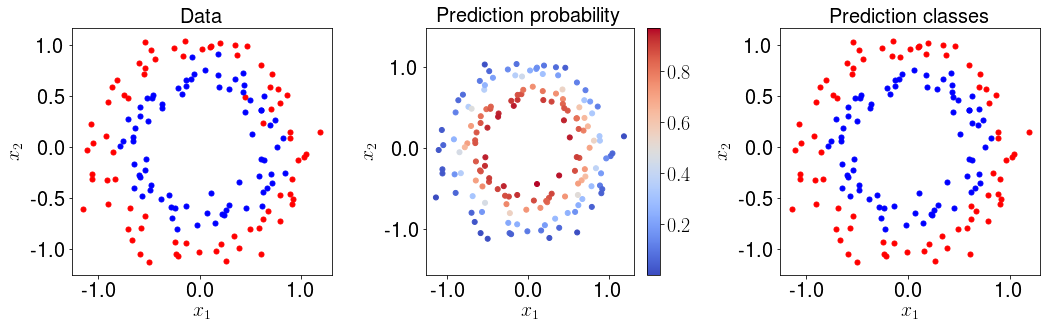

In [21]:
cmap = plt.cm.coolwarm
fig, axs = plt.subplots(1,3, figsize=(3*5,5))
axs = axs.ravel()

ax = axs[0]
ax.plot(X[y==0,0], X[y==0,1], '.r')
ax.plot(X[y==1,0], X[y==1,1], '.b')
sty.remove_tex_axis(ax, xtick_fmt="%.1f", ytick_fmt="%.1f")
ax.set_xlabel('$x_1$')    
ax.set_ylabel('$x_2$')
ax.axis('equal')
ax.set_title('Data')


ax = axs[1]
p = ax.scatter(X[:,0], X[:,1], c=sigm(X_nl, w), cmap='coolwarm', marker='.')
fig.colorbar(p, ax = ax)
sty.remove_tex_axis(ax, xtick_fmt="%.1f", ytick_fmt="%.1f")
ax.set_xlabel('$x_1$')    
ax.set_ylabel('$x_2$')
ax.axis('equal')
ax.set_title('Prediction probability')

ax = axs[2]
predictions = sigm(X_nl, w) < 0.5
ax.plot(X[predictions==0,0], X[predictions==0,1], '.b')
ax.plot(X[predictions==1,0], X[predictions==1,1], '.r')

sty.remove_tex_axis(ax, xtick_fmt="%.1f", ytick_fmt="%.1f")
ax.set_xlabel('$x_1$')    
ax.set_ylabel('$x_2$')
ax.axis('equal')
ax.set_title('Prediction classes')


plt.tight_layout()

In [22]:
w

array([ 4.91447387, -7.00621779, -6.6092362 ])